In [1]:
import os, numpy as np, config
from PIL import Image, ImageDraw

# ------------------------------------------------------------------ constants
SIDE   = 896                      # target size (square)
S      = config.S
ANCHOR = config.ANCHORS[0]        # (w₀, h₀) in relative units

# ------------------------------------------------------------------ helpers
def _rel2abs(cx, cy, w, h):
    """Relative 0-1 centre/size  →  absolute pixel corners (896×896)."""
    cx, cy, w, h = cx*SIDE, cy*SIDE, w*SIDE, h*SIDE
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

def _gt_box_from_row(row):
    """Decode (cx,cy,tx,ty,tw,th) row to absolute pixel rectangle."""
    cx = (row.cx + row.tx) / S
    cy = (row.cy + row.ty) / S
    w  = np.exp(row.tw) * ANCHOR[0]
    h  = np.exp(row.th) * ANCHOR[1]
    return _rel2abs(cx, cy, w, h)

# ------------------------------------------------------------------ main
def render_gt(gt_df, img_id,
              *, colour=(0, 255, 0, 200),
              out_dir="evaluation",
              size=SIDE):
    """
    Draw every GT box for `img_id` on an 896×896 page preview.

    Parameters
    ----------
    gt_df   : dataframe containing at least [img_id,cx,cy,tx,ty,tw,th,filename]
    img_id  : which page to render
    colour  : RGBA outline for GT boxes
    out_dir : folder where PNG is saved
    size    : output resolution (square). 896 keeps parity with training.

    Returns
    -------
    PIL.Image.Image  – the rendered picture
    """
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann.filename.iloc[0])
    pil = Image.open(img_path).convert("RGB").resize((size, size))

    draw = ImageDraw.Draw(pil, "RGBA")
    for _, row in ann.iterrows():
        draw.rectangle(_gt_box_from_row(row), outline=colour, width=2)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_gt_only.png")
    pil.save(out_path)
    print(f"[render_gt] saved → {out_path}")
    return pil


In [8]:
import util
from importlib import reload
import model as m

reload(util)
reload(config)

de = util.DataExtractor()
anns = de.normalizedData()
img_ids = anns["img_id"].unique().tolist()


Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


[render_gt] saved → evaluation\1023_gt_only.png


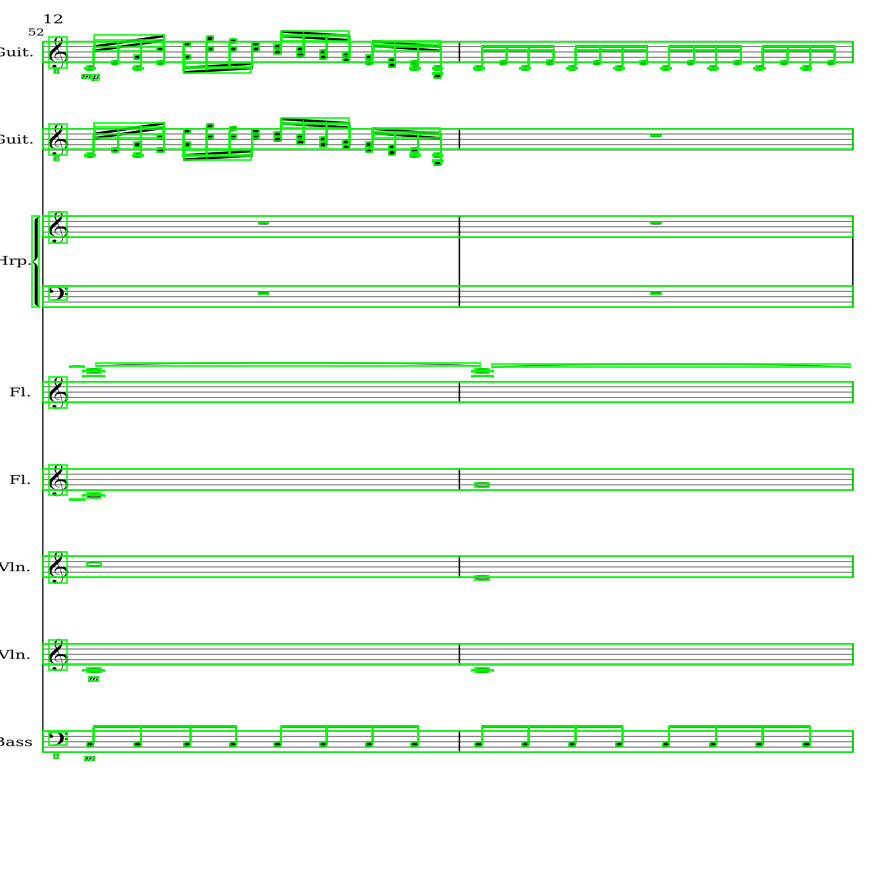

In [12]:
render_gt(anns, img_id=1023)

## Predictions

In [13]:
model = m.YOLOv2Heavy()
model = util.loadModel("concord050", model, device='cuda')
_ = render_prediction(model, anns, img_id=img_ids[0], score_thresh=0.5)


c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\util.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


RuntimeError: Error(s) in loading state_dict for YOLOv2Heavy:
	size mismatch for model.17.conv.weight: copying a param with shape torch.Size([846, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([564, 1024, 1, 1]).
	size mismatch for model.17.bn.weight: copying a param with shape torch.Size([846]) from checkpoint, the shape in current model is torch.Size([564]).
	size mismatch for model.17.bn.bias: copying a param with shape torch.Size([846]) from checkpoint, the shape in current model is torch.Size([564]).
	size mismatch for model.17.bn.running_mean: copying a param with shape torch.Size([846]) from checkpoint, the shape in current model is torch.Size([564]).
	size mismatch for model.17.bn.running_var: copying a param with shape torch.Size([846]) from checkpoint, the shape in current model is torch.Size([564]).

In [15]:
import pandas as pd
import util
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [17]:
gt_df.head()

,img_id,crop_id,cx_loc,cy_loc,tx,ty,tw,th,class_id,filename,cx,cy,crop_row,crop_col
0,679,2,12,6,0.000000,0.019192,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,60,6,0,2
1,679,2,12,11,0.000000,0.951149,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,60,11,0,2
2,679,3,21,19,0.566434,0.627799,-0.489309,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,93,19,0,3
3,679,3,21,20,0.640477,0.203548,-0.591092,-3.261793,1,lg-877777775968732096-aug-gonville--page-3.png,93,20,0,3
4,679,3,18,19,0.925545,0.627799,-0.522099,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,90,19,0,3


[render_gt] saved → evaluation\1023_gt_only.png


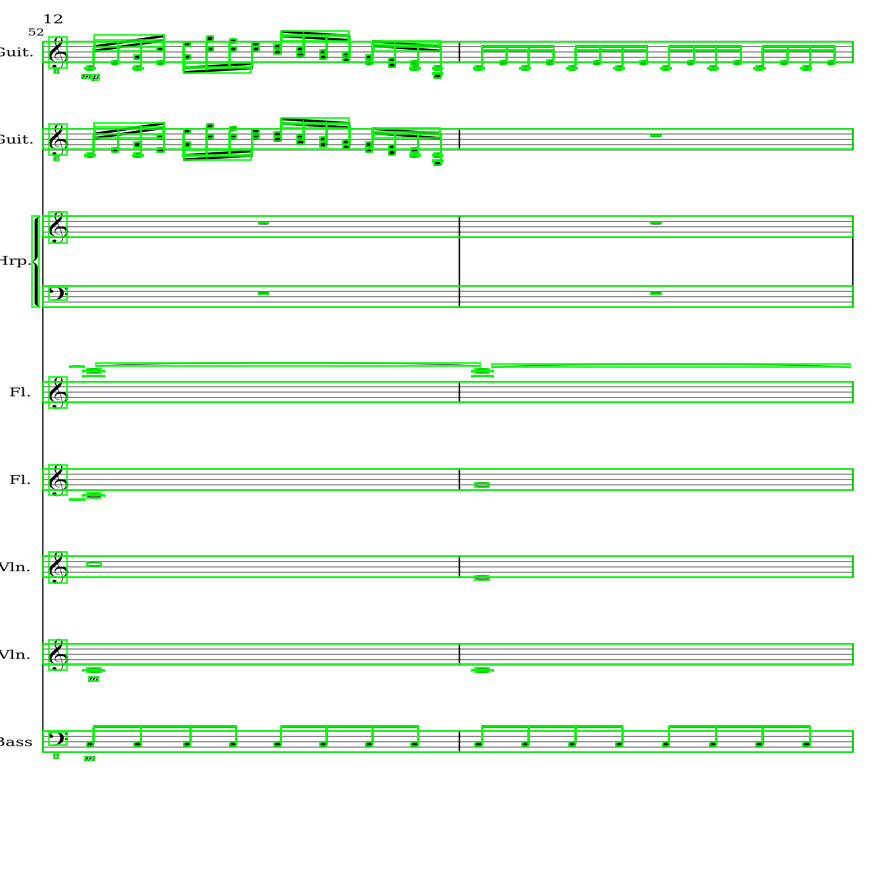

In [16]:
render_gt(anns, img_id=1023)

In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw

SIDE   = 10
S      = config.S                  # number of grid cells along each page edge
ANCHOR = config.ANCHORS[0]         # (w₀ , h₀) – relative units

# ---------------------------------------------------------------- helpers (unchanged)
def _page_rel2abs(cx, cy, w, h):
    """Page-relative (0–1) centre & size  →  absolute pixel rectangle (896×896)."""
    cx, cy, w, h = cx*SIDE, cy*SIDE, w*SIDE, h*SIDE
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

# ---------------------------------------------------------------- main
def render_crop_gt(gt_df, img_id, crop_row, crop_col,
                   *, colour=(255, 0, 0, 200),
                   out_dir="evaluation_crops",
                   size=SIDE):
    """
    Render all GT boxes whose global (cx,cy) land in crop `(crop_row, crop_col)`.

    Parameters
    ----------
    gt_df     : dataframe with at least [img_id,cx,cy,tx,ty,tw,th,crop_row,crop_col,filename]
    img_id    : full-page identifier
    crop_row  : row index of the crop in the page tiling
    crop_col  : column index of the crop in the page tiling
    colour    : RGBA outline colour
    out_dir   : output directory
    size      : pixel edge of the *output* crop preview (896 default)

    Returns
    -------
    PIL.Image.Image
    """
    page_df = gt_df[gt_df.img_id == img_id]
    if page_df.empty:
        raise ValueError(f"No rows with img_id={img_id}")

    # --------------------------------------------------- derive tiling geometry
    n_rows = int(page_df.crop_row.max()) + 1        # total crops top-to-bottom
    n_cols = int(page_df.crop_col.max()) + 1        # total crops left-to-right
    cells_y = S // n_rows                           # cells per crop vertically
    cells_x = S // n_cols                           # cells per crop horizontally

    cx_min  = crop_col * cells_x
    cx_max  = (crop_col + 1) * cells_x              # exclusive upper bound
    cy_min  = crop_row * cells_y
    cy_max  = (crop_row + 1) * cells_y

    # keep only boxes whose *global* cx,cy fall into the crop’s cell window
    ann = page_df[(page_df.cx >= cx_min) & (page_df.cx < cx_max) &
                  (page_df.cy >= cy_min) & (page_df.cy < cy_max)]
    if ann.empty:
        raise ValueError(f"No GT boxes inside crop ({crop_row},{crop_col}) of img_id={img_id}")

    # --------------------------------------------------- load & cut the image
    path  = os.path.join(config.img_dir, ann.filename.iloc[0])
    full  = Image.open(path).convert("RGB")
    W, H  = full.size

    crop_w = W // n_cols
    crop_h = H // n_rows
    left   = crop_col * crop_w
    upper  = crop_row * crop_h
    right  = left + crop_w
    lower  = upper + crop_h

    crop_img = full.crop((left, upper, right, lower)).resize((size, size))
    scale_x  = size / crop_w
    scale_y  = size / crop_h

    # --------------------------------------------------- draw boxes
    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in ann.iterrows():
        # page-level centre/size (relative 0-1)
        cx_rel = (row.cx + row.tx) / S
        cy_rel = (row.cy + row.ty) / S
        w_rel  = np.exp(row.tw) * ANCHOR[0]
        h_rel  = np.exp(row.th) * ANCHOR[1]

        # page-pixel rectangle → crop-pixel rectangle
        x0, y0, x1, y1 = _page_rel2abs(cx_rel, cy_rel, w_rel, h_rel)
        box_crop = [(x0 - left) * scale_x,
                    (y0 - upper) * scale_y,
                    (x1 - left) * scale_x,
                    (y1 - upper) * scale_y]
        draw.rectangle(box_crop, outline=colour, width=2)

    # --------------------------------------------------- save / return
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir,
                            f"{img_id}_r{crop_row}_c{crop_col}_gt.png")
    crop_img.save(out_path)
    print(f"[render_crop_gt] saved → {out_path}")
    return crop_img


[render_crop_gt] saved → evaluation_crops\679_r0_c2_gt.png


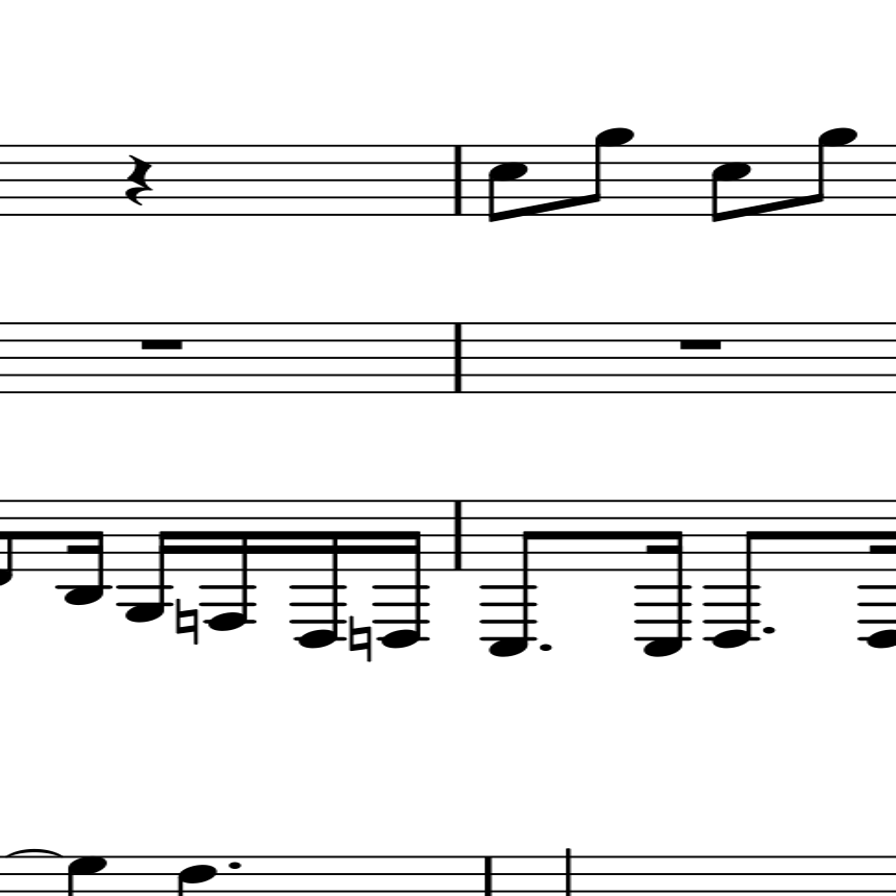

In [26]:
render_crop_gt(gt_df, img_id=679, crop_row = 0, crop_col = 2)